<a href="https://colab.research.google.com/github/Jeff-GitHu/Jeff-GitHu/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import save_image
import time

import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Image Preprocessing

Before feeding the images into any Computer Vision model, we require preprocessing of the images. The most frequently used preprocessing techniques are:
- `transforms.Resize(256)` : Resize all images to size (256, 256).
- `transforms.ToTensor()` : Converts a PIL Image to a PyTorch tensor (multi-dimensional array).

In [2]:
def image_loader(img_path):
    """Given an image path, it returns the image tensor"""

    image=Image.open(img_path).convert('RGB')
    # TODO : Implement preprocessing transform.
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()                            
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

## Loading and Visualising Images

Now we can use the `image_loader` function to load in the Style and Content images. The `image_plotter` function can then be utilised to visualise all the images.

In [3]:
# TODO: Load in the style and content images.
style_image = image_loader('./picasso-version-o.jpeg')
content_image = image_loader('fashion-model.jpeg')

In [4]:
def image_plotter(imgs):
    """Given an array of image tensors, it plots them in a grid"""
    to_PIL = transforms.ToPILImage()
    nrows = int(np.sqrt(len(imgs)))
    ncols = int(np.ceil(len(imgs)/nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*8))
    for i, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if i < len(imgs):
            img = to_PIL(imgs[i].squeeze(0))
            ax.imshow(img)
    plt.subplots_adjust(wspace=0.005, hspace=0.005)

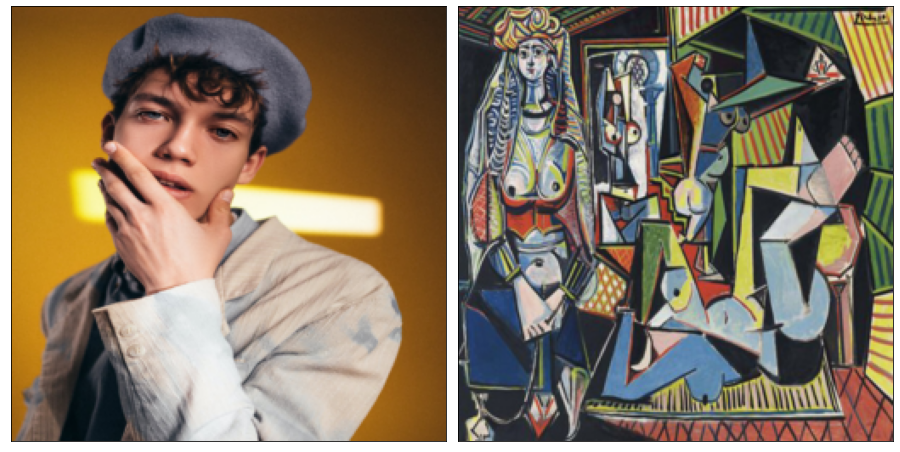

In [20]:
image_plotter([content_image, style_image])

## Model definition

Neural Style Transfer can applied using any Computer Vision model, however we replicate the [paper](https://arxiv.org/abs/1508.06576) by using a VGG-19 model pretrained on the ImageNet dataset.

We will use the feature representations of the layers indexed by `[0, 5, 10, 19, 28]`, namely, the `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1` and `conv5_1` layers.

In [48]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # TODO: Define selected indices and the base model
        self.features = [0, 5, 10, 19, 28]
        self.model = models.vgg19(pretrained=True).features[:29]
        #self.model = models.resnet(pretrained=True).features[:29]
        #self.model = models.vgg11(pretrained=True).features[:29]

    def forward(self, x):
        # TODO: Accumulate representations from the selected layers.
        representations = []

        for id, layer in enumerate(self.model):
          x = layer(x)
          if id in self.features:
            representations.append(x)
        
        return representations

## Loss function definition

The loss function for neural style transfer is defined as:
$$\mathcal{L}(\vec{G}, \vec{C}, \vec{S}) = \alpha\mathcal{L}_c(\vec{G}, \vec{C}) + \beta\mathcal{L}_s(\vec{G}, \vec{S})$$
where,
- $\mathcal{L}(\vec{G}, \vec{C}, \vec{S})$ is the total loss of the generated image $\vec{G}$ with respect to the content $\vec{C}$ and style $\vec{S}$ images.
- $\mathcal{L}_c(\vec{G}, \vec{C})$ is the content loss, which measures how similar the content image $\vec{C}$ is to the generated image $\vec{G}$.
- $\mathcal{L}_s(\vec{G}, \vec{S})$ is the style loss, which measures how similar the style image $\vec{S}$ is to the generated image $\vec{G}$.
- $\alpha$ and $\beta$ are hyper-parameters to be defined later.

To optimize the model parameters, traditional machine learning uses gradient descent on the loss function. In Neural Style Transfer, on the other hand, we use the loss to optimize the pixel values of the input image. We can make the input image emphasize either the style or the content image by choosing suitable values for $\alpha$ and $\beta$.

### Content Loss

The content loss is the mean squared error (MSE) between the representations of the content $\vec{C}$ and the generated $\vec{G}$ image at the $l^{th}$ layer, and can be defined as follows:
$$\mathcal{L}_c(\vec{G}, \vec{C}, l) = \frac{1}{2}\left\lVert C^{[l]} - G^{[l]}\right\rVert ^ 2$$
where,
- $C^{[l]}$ is the activation of the $l^{th}$ layer on the content image $\vec{C}$.
- $G^{[l]}$ is the activation of the $l^{th}$ layer on the generated image $\vec{G}$.

In [49]:
def content_loss(G, C):
    loss = F.mse_loss(G, C)
    return loss

### Style Loss

Similarly, the style loss is the mean squared error (MSE) betwen the gram matrices of the representation of the style $\vec{S}$ and the generated $\vec{G}$ images at the $l^{th}$ layer.

$$\mathcal{L}_s(\vec{G}, \vec{S}, l) = \left( \frac{1}{2n^{[l]}_Cn^{[l]}_Hn^{[l]}_W} \right)^2 \left\lVert C^{[l]}_{gram} - G^{[l]}_{gram}\right\rVert ^ 2$$
where,
- $C^{[l]}_{gram}$ and is the Gram Matrix of content image $\vec{C}$ at the $l^{th}$ layer.
- $G^{[l]}_{gram}$ and is the Gram Matrix of generated image $\vec{G}$ at the $l^{th}$ layer.
- $n^{[l]}_C$, $n^{[l]}_H$, $n^{[l]}_W$ are the number of channels, height and width respectively of the image at the $l^{th}$ layer.

In [50]:
def style_loss(G, S):

    def gram_matrix(a):
        B, C, H, W = a.shape
        A = a.reshape(B*C, H*W)
        return torch.matmul(A, A.t()).div(B*C*H*W)

    S_gram = gram_matrix(S)
    G_gram = gram_matrix(G)

    return F.mse_loss(G_gram, S_gram)

### Total Loss
As defined previously, the total loss function for neural style transfer is defined as:
$$\mathcal{L}(\vec{G}, \vec{C}, \vec{S}) = \alpha\mathcal{L}_c(\vec{G}, \vec{C}) + \beta\mathcal{L}_s(\vec{G}, \vec{S})$$

In [51]:
def total_loss(G, C, S, alpha=1, beta=1e8):
    style_loss_val = 0
    content_loss_val = 0

    # TODO: Calculate the style and content loss for 

    for g, c, s in zip(G, C, S):
        content_loss_val += content_loss(g, c)
        style_loss_val += style_loss(g, s)

    total_loss = alpha*content_loss_val + beta*style_loss_val

    return total_loss

## Inference

Now given a style image and a content image, we can begin from white noise to generate our neural style transfer image. However, cloning the content image as the initial generated image usually gives better results.

In [52]:
def style_transfer(G, C, S, model, epochs, loss_function, optimizer):
    tic = time.time()
    for epoch in range(epochs):

        # TODO: Pass in G, C, S through the model and calculate and back prop the loss.
        G_reps = model(G)
        C_reps = model(C)
        S_reps = model(S)

        loss = total_loss(G_reps, C_reps, S_reps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%200==0 or epoch==epochs-1:
            toc = time.time()
            print(f'Epoch: {epoch+1:4d}/{epochs} | Total Loss: {torch.mean(loss):.3f} | Time: {toc-tic:.2f}s')
            save_image(G.squeeze(0), 'generated_image.jpeg')
            tic = time.time()

We can run the inference loop for 1000 epochs. It's worth noting that we usually pass the model parameters to the optimizer, but in this case, because we want to optimize the image, we pass the input white noise image to the optimizer.

In [53]:
# TODO: Clone the content image
generated_image = content_image.clone().requires_grad_(True)

In [54]:
# The model is set to evaluation mode since we are not training the model.
nst_model = VGG().to(device).eval()
optimizer = optim.Adam([generated_image], lr=0.001)

style_transfer(generated_image, content_image, style_image, nst_model, 4000, total_loss, optimizer)

Epoch:    1/4000 | Total Loss: 89092.945 | Time: 0.18s
Epoch:  201/4000 | Total Loss: 3284.659 | Time: 19.09s
Epoch:  401/4000 | Total Loss: 1822.499 | Time: 19.27s
Epoch:  601/4000 | Total Loss: 1241.626 | Time: 19.42s
Epoch:  801/4000 | Total Loss: 957.062 | Time: 19.56s
Epoch: 1001/4000 | Total Loss: 803.588 | Time: 19.68s
Epoch: 1201/4000 | Total Loss: 704.262 | Time: 19.77s
Epoch: 1401/4000 | Total Loss: 632.453 | Time: 19.86s
Epoch: 1601/4000 | Total Loss: 578.478 | Time: 19.92s
Epoch: 1801/4000 | Total Loss: 536.926 | Time: 19.95s
Epoch: 2001/4000 | Total Loss: 503.780 | Time: 19.99s
Epoch: 2201/4000 | Total Loss: 476.488 | Time: 19.99s
Epoch: 2401/4000 | Total Loss: 453.613 | Time: 20.04s
Epoch: 2601/4000 | Total Loss: 434.164 | Time: 20.04s
Epoch: 2801/4000 | Total Loss: 417.459 | Time: 20.05s
Epoch: 3001/4000 | Total Loss: 402.740 | Time: 20.06s
Epoch: 3201/4000 | Total Loss: 389.302 | Time: 20.10s
Epoch: 3401/4000 | Total Loss: 377.051 | Time: 20.07s
Epoch: 3601/4000 | Total

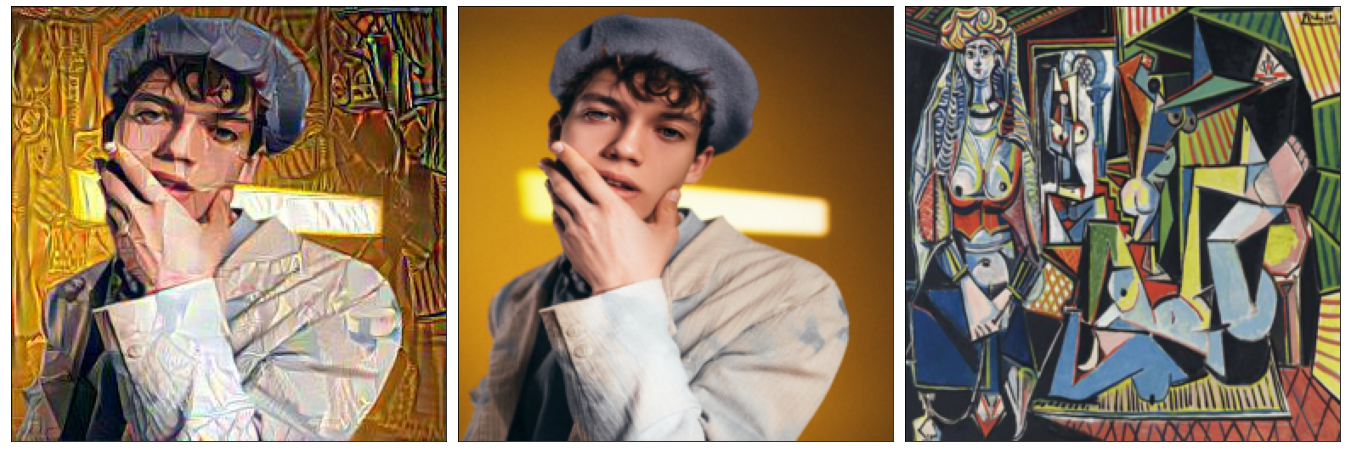

In [55]:
final_image = image_loader('generated_image.jpeg')
image_plotter([final_image, content_image, style_image])